##Imports and definitions

In [ ]:
!pip install 'tensorflow==1.15.0'
import tensorflow as tf

!pip install 'kaggle-environments>=0.1.6'
from kaggle_environments import make, evaluate

!apt-get update
!apt-get install -y cmake libopenmpi-dev python3-dev zlib1g-dev
!pip install "stable-baselines[mpi]==2.9.0"
from stable_baselines.bench import Monitor 
from stable_baselines.common.vec_env import DummyVecEnv        
from stable_baselines import PPO1, A2C  
from stable_baselines.a2c.utils import conv, linear, conv_to_fc
from stable_baselines.common.policies import CnnPolicy, MlpPolicy
from stable_baselines.a2c import utils

from gym import spaces
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
import random
import numpy as np
import pandas as pd
import os
from os import system
import time
from time import sleep
from google.colab import output, files
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import output
clear = output.clear

###Set up environments

In [ ]:
class ConnectFourGym:
    def __init__(self, opponent="random", position=1):
        ks_env = make("connectx", debug=True)
        if position == 1:
            self.env = ks_env.train([None, opponent])
        else:
            self.env = ks_env.train([opponent, None])
        self.obs = self.env.reset()  #originally only in reset
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(self.rows,self.columns,1), 
                                            dtype=np.int)
        # Tuple corresponding to the min and max possible rewards
        self.actionsize = self.rows*self.columns
        self.reward_range = (-10, 1 + 21/self.actionsize)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1)
    
    def change_reward(self, step_reward, done):
        
        if step_reward == 1: # The agent won the game
            return 1 # + 1/self.actionsize
        elif done: # The opponent won the game: sr = -1
            return -1
        else: # Reward 1/42        sr = 0
            return 1/self.actionsize
    
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0) # first 7 are top row
        if is_valid: # Play the move
            self.obs, step_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(step_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1), reward, done, _

In [ ]:
# Create directory for logging training information
log_dir = "logs/"
log_dirGX = log_dir+"logsGX/"
log_dirGY = log_dir+"logsGY/"
log_dirGZ  = log_dir+"logsGZ/"
log_dirGZZ = log_dir+"logsGZZ/"

log_dirX = log_dir+"logsX/"
log_dirY = log_dir+"logsY/"
log_dirZ = log_dir+"logsZ/"
log_dirZZ = log_dir+"logsZZ/"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(log_dirGX, exist_ok=True)
os.makedirs(log_dirGY, exist_ok=True)
os.makedirs(log_dirGZ, exist_ok=True)
os.makedirs(log_dirGZZ, exist_ok=True)
os.makedirs(log_dirX, exist_ok=True)
os.makedirs(log_dirY, exist_ok=True)
os.makedirs(log_dirZ, exist_ok=True)
os.makedirs(log_dirZZ, exist_ok=True)

def guesstimator():
    return 0
# Create ConnectFour environments
envGX = ConnectFourGym(opponent=guesstimator, position=1)
envGY = ConnectFourGym(opponent=guesstimator, position=2)
envGZ = ConnectFourGym(opponent=guesstimator, position=2)
envGZZ = ConnectFourGym(opponent=guesstimator, position=1)
envX = ConnectFourGym(opponent="random", position=1)
envY = ConnectFourGym(opponent="random", position=2)
envZ = ConnectFourGym(opponent="random", position=2)
envZZ = ConnectFourGym(opponent="random", position=1)

# Logging progress
monitor_envGX = Monitor(envGX, log_dirGX, allow_early_resets=True)
monitor_envGY = Monitor(envGY, log_dirGY, allow_early_resets=True)
monitor_envGZ = Monitor(envGZ, log_dirGZ, allow_early_resets=True)
monitor_envGZZ = Monitor(envGZZ, log_dirGZZ, allow_early_resets=True)
monitor_envX = Monitor(envX, log_dirX, allow_early_resets=True)
monitor_envY = Monitor(envY, log_dirY, allow_early_resets=True)
monitor_envZ = Monitor(envZ, log_dirZ, allow_early_resets=True)
monitor_envZZ = Monitor(envZZ, log_dirZZ, allow_early_resets=True)

# Create a vectorized environment
vec_envGZ = DummyVecEnv([lambda: monitor_envGZ])
vec_envGX = DummyVecEnv([lambda: monitor_envGX])
vec_envGY = DummyVecEnv([lambda: monitor_envGY])
vec_envGZZ = DummyVecEnv([lambda: monitor_envGZZ])
vec_envX = DummyVecEnv([lambda: monitor_envX])
vec_envY = DummyVecEnv([lambda: monitor_envY])
vec_envZ = DummyVecEnv([lambda: monitor_envZ])
vec_envZZ = DummyVecEnv([lambda: monitor_envZZ])

# Parameters directory
params_dir = "params/"
os.makedirs(params_dir, exist_ok=True)


##Training

###Build opponents

In [ ]:
# Neural network for predicting action values

def cnn_extractor_X(board):
    relu = tf.nn.relu
    leaky = tf.nn.leaky_relu
    #batnorm = tf.nn.batch_normalization()
    # 6 x 7 x 1
    c1 = relu(conv( board, 'c1', n_filters=32, 
                    filter_size=2, stride=1, pad="VALID",
                    init_scale=np.sqrt(2) ))
    # 5 x 6 x 32
    c2 = relu(conv( c1, 'c2', n_filters=64, 
                    filter_size=(2,3), stride=1, pad="VALID",
                    init_scale=np.sqrt(2) ))
    # 4 x 4 x 64
    c3 = relu(conv( c2, 'c3', n_filters=128, 
                    filter_size=3, stride=1, pad="SAME",
                    init_scale=np.sqrt(2) ))
    # 4 x 4 x 128
    flatten = leaky(conv_to_fc(c3))
    classifier = leaky(linear(flatten, 'classifier',
                              n_hidden=512, 
                              init_scale=np.random.normal(np.sqrt(2), 0.1) ))
    return relu(linear(classifier, 'out', n_hidden=128, 
                       init_scale=np.random.normal(np.sqrt(2), 0.01) ))

class CustomCnnPolicyX(CnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicyX, self).__init__(*args, **kwargs, cnn_extractor=cnn_extractor_X)
        
# Initialize agent
#modelX = A2C(CustomCnnPolicyX, vec_env, verbose=0, learning_rate= 0.001, n_steps=42, _init_setup_model=True)

In [ ]:
# Neural network for predicting action values

def cnn_extractor_Z(board):
    relu = tf.nn.relu
    leaky = tf.nn.leaky_relu
    #batnorm = tf.nn.batch_normalization()
    # 6 x 7 x 1
    c1 = relu(conv( board, 'c1', n_filters=32, 
                    filter_size=2, stride=1, pad="VALID",
                    init_scale=np.sqrt(2) ))
    # 5 x 6 x 32
    c2 = relu(conv( c1, 'c2', n_filters=64, 
                    filter_size=(2,3), stride=1, pad="VALID",
                    init_scale=np.sqrt(2) ))
    # 4 x 4 x 64
    c3 = relu(conv( c2, 'c3', n_filters=128, 
                    filter_size=3, stride=1, pad="SAME",
                    init_scale=np.sqrt(2) ))
    # 4 x 4 x 128
    c4 = relu(conv( c2, 'c4', n_filters=128, 
                    filter_size=3, stride=1, pad="SAME",
                    init_scale=np.sqrt(2) ))
    # 4 x 4 x 128
    flatten = leaky(conv_to_fc(c3 + c4))
    classifier1 = leaky(linear(flatten, 'classifier1',
                              n_hidden=768, 
                              init_scale=np.random.normal(np.sqrt(2), 0.1) ))
    classifier2 = leaky(linear(classifier1, 'classifier2',
                              n_hidden=256, 
                              init_scale=np.random.normal(np.sqrt(2), 0.1) ))    
    return relu(linear(classifier2, 'out', n_hidden=64, 
                       init_scale=np.random.normal(np.sqrt(2), 0.01) ))

class CustomCnnPolicyZ(CnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicyZ, self).__init__(*args, **kwargs, cnn_extractor=cnn_extractor_Z)
        
# Initialize agent
#modelZ = A2C(CustomCnnPolicyZ, vec_envZ, verbose=0, learning_rate= 0.001)#, n_steps=42, _init_setup_model=True)

In [ ]:
# Neural network for predicting action values

def cnn_extractor_ZZ(board):
    relu = tf.nn.relu
    leaky = tf.nn.leaky_relu
    drop = tf.nn.dropout
    #batnorm = tf.nn.batch_normalization

    # >>> 6 x 7 x 1
    inL = relu(conv( board, 'inL', n_filters=32, 
                    filter_size=2, stride=1, pad="VALID",
                    init_scale=np.sqrt(2) ))
    # 5 x 6 x 32
    cL1 = relu(conv(inL, 'cL1', n_filters=64, 
                    filter_size=(2,3), stride=1, pad="VALID",
                    init_scale=np.sqrt(2) ))
    # 4 x 4 x 64
    cLL1 = relu(conv( cL1, 'cLL1', n_filters=128, 
                    filter_size=3, stride=1, pad="SAME",
                    init_scale=np.sqrt(2) ))
    # 4 x 4 x 64
    cLR1 = relu(conv( cL1, 'cLR1', n_filters=128, 
                    filter_size=3, stride=1, pad="SAME",
                    init_scale=np.sqrt(2) ))
    
    # >>> 6 x 7 x 1
    inR = relu(conv( board, 'inR', n_filters=32, 
                    filter_size=2, stride=1, pad="VALID",
                    init_scale=np.sqrt(2) ))
    # 5 x 6 x 32
    cR1 = relu(conv(inR, 'cR1', n_filters=64, 
                    filter_size=(2,3), stride=1, pad="VALID",
                    init_scale=np.sqrt(2) ))
    # 4 x 4 x 64
    cRL1 = relu(conv( cR1, 'cRL1', n_filters=64, 
                    filter_size=3, stride=1, pad="SAME",
                    init_scale=np.sqrt(2) ))
    # 4 x 4 x 64
    cRL2 = relu(conv( cRL1, 'cRL2', n_filters=128, 
                    filter_size=3, stride=1, pad="SAME",
                    init_scale=np.sqrt(2) ))
    
    # 4 x 4 x 64
    cRR1 = relu(conv( cR1, 'cRR1', n_filters=64, 
                    filter_size=3, stride=1, pad="SAME",
                    init_scale=np.sqrt(2) ))
    
    # 4 x 4 x 128
    cRR2 = relu(conv( cRR1, 'cRR2', n_filters=128, 
                    filter_size=3, stride=1, pad="SAME",
                    init_scale=np.sqrt(2) ))
    

    # >>> 4 x 4 x 128
    # classifier
    flattenL = leaky(conv_to_fc(cLL1 + cLR1))
    flattenR = leaky(conv_to_fc(cRL2 + cRR2))
    flatten = (flattenL + flattenR)
    classifier1 = leaky(linear(flatten, 'classifier1', n_hidden=768))
    classifier1 = drop(classifier1, rate=0.2)
    classifier2 = leaky(linear(classifier1, 'classifier2', n_hidden=256)) 
    classifier2 = drop(classifier2, rate=0.1)  
    return relu(linear(classifier2, 'out', n_hidden=64))

class CustomCnnPolicyZZ(CnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicyZZ, self).__init__(*args, **kwargs, cnn_extractor=cnn_extractor_ZZ)
        
# Initialize agent
#modelZZ = A2C(CustomCnnPolicyZZ, vec_envZZ, verbose=0, learning_rate= 0.001, n_steps=42, _init_setup_model=True)

In [ ]:
# Neural network for predicting action values

def cnn_extractor_ZZZ(board):
    relu = tf.nn.relu
    leaky = tf.nn.leaky_relu
    drop = tf.nn.dropout
    #batnorm = tf.nn.batch_normalization

    # >>> 6 x 7 x 1
    inL = relu(conv( board, 'inL', n_filters=64, 
                    filter_size=2, stride=1, pad="VALID",
                    init_scale=np.sqrt(2) ))
    # 5 x 6 x 64
    cL = relu(conv(inL, 'cL1', n_filters=128, 
                    filter_size=(2,3), stride=1, pad="VALID",
                    init_scale=np.sqrt(2) ))
    # 4 x 4 x 128
    cLL1 = relu(conv( cL, 'cLL1', n_filters=256, 
                    filter_size=3, stride=1, pad="SAME",
                    init_scale=np.sqrt(2) ))
    # 4 x 4 x 128
    cLR1 = relu(conv( cL, 'cLR1', n_filters=256, 
                    filter_size=3, stride=1, pad="SAME",
                    init_scale=np.sqrt(2) ))

    c2L = cLL1 + cLR1
    c2L = relu(conv( c2L, 'c2L', n_filters=512, 
                    filter_size=2, stride=1, pad="SAME")) 

    # >>> 6 x 7 x 1
    inR = relu(conv( board, 'inR', n_filters=64, 
                    filter_size=2, stride=1, pad="VALID",
                    init_scale=np.sqrt(2) ))
    # 5 x 6 x 64
    cR = relu(conv(inR, 'cR', n_filters=128, 
                    filter_size=(2,3), stride=1, pad="VALID",
                    init_scale=np.sqrt(2) ))
    # >> 4 x 4 x 128
    cRL1 = relu(conv( cR, 'cRL1', n_filters=256, 
                    filter_size=3, stride=1, pad="SAME",
                    init_scale=np.sqrt(2) ))
    cRL1 = (cRL1 + cLL1)/2.0
    # 4 x 4 x 128
    cRL2 = relu(conv( cRL1, 'cRL2', n_filters=256, 
                    filter_size=2, stride=1, pad="SAME",
                    init_scale=np.sqrt(2) ))
    
    # >> 4 x 4 x 64
    cRR1 = relu(conv( cR, 'cRR1', n_filters=128, 
                    filter_size=2, stride=1, pad="SAME",
                    init_scale=np.sqrt(2) ))
    
    # 4 x 4 x 128
    cRR2 = relu(conv( cRR1, 'cRR2', n_filters=256, 
                    filter_size=3, stride=1, pad="SAME",
                    init_scale=np.sqrt(2) ))
    cRR2 = (cRR2 + cLR1)/2.0

    # >>> 4 x 4 x 128
    # classifier
    flattenL = leaky(conv_to_fc(c2L))
    flattenR = leaky(conv_to_fc(cRL2 + cRR2))
    flatten = leaky(drop(conv_to_fc(cL+cR), rate=0.2))
    classL1 = leaky(drop(linear(flattenL, 'classL1', n_hidden=512), rate=0.2))
    classR1 = leaky(drop(linear(flattenR, 'classR1', n_hidden=512), rate=0.4))
    classA = leaky(drop(linear(flatten, 'classA', n_hidden=1024), rate=0.3)) 
    classA1 = leaky(drop(linear(classA, 'classA1', n_hidden=512), rate=0.3)) 
    classB = classL1 + classR1
    classB1 = leaky(drop(linear(classB, 'classB1', n_hidden=512), rate=0.1))  
    classC = classA1 + classB1
    classC1 = leaky(drop(linear(classC, 'classC1', n_hidden=256), rate=0.1))
    classC2 = leaky(drop(linear(classC1, 'classC2', n_hidden=128), rate=0.1))
    return relu(linear(classC2, 'out', n_hidden=64 ))

class CustomCnnPolicyZZZ(CnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicyZZZ, self).__init__(*args, **kwargs, cnn_extractor=cnn_extractor_ZZZ)
        
# Initialize agent
modelZZZ = A2C(CustomCnnPolicyZZZ, vec_envZ, verbose=0, learning_rate= 0.001)#, n_steps=21, _init_setup_model=True)

In [ ]:
modelZZZ.get_parameter_list()

In [ ]:
def guesstimator(obs, config, N_STEPS=2, debug=False):

    ###########################
    # constants (given by game)
    ROWS = 6
    COLUMNS = 7
    CNCTX = 4
    #config = {"rows":ROWS, "columns":COLUMNS, "inarow":CNCTX}
    ## coefficients
    A = 2     #my twos
    B = 20    #my threes
    C = 200   #my fours
    D = -1    #opp-twos
    E = -10    #opp-threes
    F = -100   #opp-fours
    
    # printout every few
    

    # vary lookahead depth according to number finished columns:
    if obs.board.count(0) < ROWS*COLUMNS//2 + 6:
        N_STEPS =      3   
    if obs.board[:7].count(0) < 4:
        N_STEPS =      5      
    elif obs.board[:7].count(0) < 6:
        N_STEPS =      3          

    if debug:
        print(f'\n###### Agent Turn: {obs.board.count(1):02} ######') 
        print(f'Using {N_STEPS} step lookahead')

    # Gets obs.board at next step if agent drops piece in selected column
    def drop_piece(grid, col, mark):
        next_grid = grid.copy()
        for row in range(ROWS-1, -1, -1):    
            if next_grid[row][col] == 0:
                next_grid[row][col] = mark
                break
        return next_grid

    # Helper function for get_score: checks if window satisfies heuristic conditions
    def check_window(window, num_discs, piece):
        return (window.count(piece) == num_discs and window.count(0) == CNCTX-num_discs)

    # Helper function for get_score: counts number of windows satisfying specified heuristic conditions
    def count_windows(grid, num_discs, piece):
        num_windows = 0
        # horizontal
        for row in range(ROWS):
            for col in range(COLUMNS-(CNCTX-1)):
                window = list(grid[row, col:col+CNCTX])
                if check_window(window, num_discs, piece):
                    num_windows += 1
        # vertical
        for row in range(ROWS-(CNCTX-1)):
            for col in range(COLUMNS):
                window = list(grid[row:row+CNCTX, col])
                if check_window(window, num_discs, piece):
                    num_windows += 1
        # positive diagonal
        for row in range(ROWS-(CNCTX-1)):
            for col in range(COLUMNS-(CNCTX-1)):
                window = list(grid[range(row, row+CNCTX), range(col, col+CNCTX)])
                if check_window(window, num_discs, piece):
                    num_windows += 1
        # negative diagonal
        for row in range(CNCTX-1, ROWS):
            for col in range(COLUMNS-(CNCTX-1)):
                window = list(grid[range(row, row-CNCTX, -1), range(col, col+CNCTX)])
                if check_window(window, num_discs, piece):
                    num_windows += 1
        return num_windows

    def check_fours(grid, mark):
        num_fours = count_windows(grid, 4, mark)   #C
        num_fours_opp = count_windows(grid, 4, mark%2+1)  #F
        is_terminal = (num_fours != 0) or (num_fours_opp != 0) or (list(grid[0, :]).count(0) == 0)
        return num_fours, num_fours_opp, is_terminal
    
    # Helper function for alphabeta: calculates value of heuristic for grid
    def get_score(grid, mark):
        is_terminal = False
        num_fours, num_fours_opp, is_terminal = check_fours(grid,mark)
        if is_terminal:
            return C*num_fours + F*num_fours_opp, is_terminal
        num_twos = count_windows(grid, 2, mark) #A
        num_threes = count_windows(grid, 3, mark)  #B
        num_twos_opp = count_windows(grid, 2, mark%2+1) #D
        num_threes_opp = count_windows(grid, 3, mark%2+1) #E
        score = A*num_twos + B*num_threes + C*num_fours + D*num_twos_opp + E*num_threes_opp + F*num_fours_opp
        return score, is_terminal

    # Minimax with alphabeta pruning implementation:
    def alphabeta(node, depth, alpha, beta, maximizingPlayer, mark):
        node_score, is_terminal = get_score(node, mark)
        if depth == 0 or is_terminal:
            return node_score
        valid_moves = [c for c in range(COLUMNS) if node[0][c] == 0]
        if maximizingPlayer:
            value = -np.Inf
            for col in valid_moves:
                child = drop_piece(node, col, mark)
                value = max(value, alphabeta(child, depth-1, alpha, beta, False, mark))
                alpha = max(alpha, value)
                if alpha >= beta:
                    break
            return value
        else: #minimizing player
            value = np.Inf
            for col in valid_moves:
                child = drop_piece(node, col, mark%2+1)
                value = min(value, alphabeta(child, depth-1, alpha, beta, True, mark))
                beta = min(beta, value)
                if alpha >= beta:
                    break
            return value

    # Uses alphabeta pruning to calculate value
    # of dropping piece in selected column
    def score_move(grid, col, mark, depth):
        next_grid = drop_piece(grid, col, mark)
        score = alphabeta(next_grid, depth-1, -np.Inf, np.Inf, False, mark)
        if debug:
            summary_stats = {'column': col, 'score': score}
            print(f'"summary_stats":{summary_stats}')
        return score
    
    def first_pass(grid, col, mark):
        _,_, self_is_terminal = check_fours(drop_piece(grid, col, mark), mark)
        #if self_is_terminal:
        return self_is_terminal
        #_,_, opp_is_terminal = check_fours(drop_piece(grid, col, mark%2+1), mark%2+1)
        #return opp_is_terminal
        
    def get_probs(valid_scores, valid_moves):
        scores = list(valid_scores.values())
        min_score = np.min(scores)
        max_score = np.max(scores)
        if min_score <= 0.0:
            if max_score <= 0.0:
                scores = [s-min_score+0.001 for s in scores]
            else:
                scores = [0.001 if s<=0 else s for s in scores]
        #else: no action
        sum_scores = np.sum(scores)
        valid_probs = {m:s for m,s in zip(valid_moves, scores/sum_scores)}
        probs = [valid_probs[i] if i in valid_moves else 0.0 for i in range(7)]
        return probs

    #########################
    # Agent makes selection #
    #########################

    # Get list of valid moves
    valid_moves = [c for c in range(COLUMNS) if obs.board[c] == 0]

    # Convert the obs.board to a 2D grid
    grid = np.asarray(obs.board).reshape(ROWS, COLUMNS)

    # Do a quick pass at depth zero to see if there is a positive terminal node
    quick_pick = False
    for col in valid_moves:
        quick_pick = first_pass(grid, col, obs.mark)
        if quick_pick:
            choice = col  
            probs = [1.0 if i == col else 0.0 for i in range(7)] 
            if debug:
                print("Column {} is terminal.".format(choice))
            break
    
    if not quick_pick:  
        #if np.random.choice([False, True, True]):
        valid_scores = dict(zip(valid_moves, [score_move(grid, col, obs.mark, N_STEPS) for col in valid_moves]))
        probs = get_probs(valid_scores, valid_moves)
        choice = int(np.random.choice(list(range(7)), p=probs))
        #else:
            #probs = ["random"]
            #choice = int(np.random.choice(valid_moves))     
    
    if debug:
        print("Probabilities:", probs,"\nChoice:",choice)

    return choice

In [ ]:
def get_agent(obs, config, model):
    col, _ = model.predict(np.array(obs['board']).reshape(6,7,1))
    is_valid = (obs['board'][int(col)] == 0)
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [ ]:
def plot_scores(dfs, epoch, lookback=100):
    f, axarr = plt.subplots(2,1, figsize=(18,6))

    ax=axarr[0]
    ax.set_title("Epoch "+str(epoch)+": score/game rolling avg over last "+str(lookback)+" games")
    ax.plot(dfs[0]['r'].rolling(window=lookback).mean(), c="blue")
    ax.plot(dfs[1]['r'].rolling(window=lookback).mean(), c="red")
    ax.legend(['1','2'])
    ax.grid(b=True)

    ax=axarr[1]
    ax.set_title("moves / game")
    dfs[0]['l'].rolling(window=lookback).mean().plot()
    dfs[1]['l'].rolling(window=lookback).mean().plot()
    ax.legend(['1','2'])
    ax.grid(b=True)


In [ ]:
def get_times(dfs):
    tdfs=[]
    for xy in [0,1]:
        ms_gm = [0]+[1000*(dfs[xy]['t'].iloc[i] - dfs[xy]['t'].iloc[i-1]) for i in range(1, len(dfs[xy]))]
        ms_mv = [(ms_gm[i] / dfs[xy]['l'].iloc[i] ) for i in range(0, len(ms_gm))]
        ms_gm_avg = np.mean(ms_gm)
        ms_mv_avg = np.mean(ms_mv)
        ms_gm[0] = ms_gm_avg
        ms_mv[0] = ms_mv_avg
        tdfs.append(pd.DataFrame(np.array([ms_gm, ms_mv]).T, columns=["ms/gm","ms/mv"]))
    return tdfs

#tdfs = get_times(dfs)
#plot_times(tdfs)

In [ ]:
f, axarr = plt.subplots(2,1, figsize=(9,5))
ax=axarr[0]
ax.set_ylim(bottom=0, top=120)

In [ ]:
def plot_times(tdfs, lookback=100):
    f, axarr = plt.subplots(2,1, figsize=(18,6))

    ax=axarr[0]
    ax.set_title("ms / game")
    ax.plot(tdfs[0]['ms/gm'].rolling(window=lookback).mean(), c="blue")
    ax.plot(tdfs[1]['ms/gm'].rolling(window=lookback).mean(), c="red")
    ax.legend(['1','2'])
    ax.grid(b=True)

    ax=axarr[1]
    ax.set_title("ms / move")
    tdfs[0]['ms/mv'].rolling(window=lookback).mean().plot()
    tdfs[1]['ms/mv'].rolling(window=lookback).mean().plot()
    ax.legend(['1','2'])
    ax.grid(b=True)
    #ax.set_ylim(bottom=0, top=40)

In [ ]:
plot_scores(dfs,2,200)
plot_times(tdfs,200)
#tdfs[0]

###Pre-Train 
~ against heuristic agent ~

In [ ]:
## Set up training GX, GY vs guesstimator
if 0:
    envGX = ConnectFourGym(opponent=guesstimator, position=1)
    envGY = ConnectFourGym(opponent=guesstimator, position=2)
    monitor_envGX = Monitor(envGX, log_dirGX, allow_early_resets=True)
    monitor_envGY = Monitor(envGY, log_dirGY, allow_early_resets=True)
    vec_envGX = DummyVecEnv([lambda: monitor_envGX])
    vec_envGY = DummyVecEnv([lambda: monitor_envGY])
    modelX = A2C(CustomCnnPolicyX, vec_envGX, verbose=0, learning_rate=0.001)
    modelX.load_parameters('params/modelX_params.zip')
    modelY = A2C(CustomCnnPolicyX, vec_envGY, verbose=0, learning_rate=0.001)
    modelY.load_parameters('params/modelY_params.zip')

In [ ]:
## Set up training GZ, GY vs guesstimator
if 0:
    envGZ = ConnectFourGym(opponent=guesstimator, position=1)
    monitor_envGZ = Monitor(envGZ, log_dirGZ, allow_early_resets=True)
    vec_envGZ = DummyVecEnv([lambda: monitor_envGZ])
    modelZ = A2C(CustomCnnPolicyZ, vec_envGZ, verbose=0, learning_rate=0.001)
    modelZ.load_parameters('params/modelZ_params.zip')  #('/content/highscorerG_Z.zip')

    envGY = ConnectFourGym(opponent=guesstimator, position=2)
    monitor_envGY = Monitor(envGY, log_dirGY, allow_early_resets=True)
    vec_envGY = DummyVecEnv([lambda: monitor_envGY])
    modelY = A2C(CustomCnnPolicyZ, vec_envGY, verbose=0, learning_rate=0.001) # n_steps=42, _init_setup_model=True)
    modelY.load_parameters('params/modelY_params.zip')  #highscorerG_Y.zip')

In [ ]:
env = ConnectFourGym(opponent=guesstimator, position=1)
env.obs

In [ ]:
## Set up training GZZ, GY vs guesstimator
envGZZ = ConnectFourGym(opponent=guesstimator, position=1)
monitor_envGZZ = Monitor(envGZZ, log_dirGZZ, allow_early_resets=True)
vec_envGZZ = DummyVecEnv([lambda: monitor_envGZZ])
modelZZ = A2C(CustomCnnPolicyZZ, vec_envGZZ, verbose=0, learning_rate=0.001)
modelZZ.load_parameters('params/modelZZ_params.zip') 

envGY = ConnectFourGym(opponent=guesstimator, position=2)
monitor_envGY = Monitor(envGY, log_dirGY, allow_early_resets=True)
vec_envGY = DummyVecEnv([lambda: monitor_envGY])
modelY = A2C(CustomCnnPolicyZ, vec_envGY, verbose=0, learning_rate=0.001) # n_steps=42, _init_setup_model=True)
modelY.load_parameters('params/modelY_params.zip') 

In [ ]:
## Set up training GZZZ, GY vs guesstimator
envGZ = ConnectFourGym(opponent=guesstimator, position=1)
monitor_envGZ = Monitor(envGZ, log_dirGZ, allow_early_resets=True)
vec_envGZ = DummyVecEnv([lambda: monitor_envGZ])
modelZZZ = A2C(CustomCnnPolicyZZZ, vec_envGZ, verbose=0, learning_rate=0.001)
modelZZZ.load_parameters('params/modelZZZ_params.zip') 

envGY = ConnectFourGym(opponent=guesstimator, position=2)
monitor_envGY = Monitor(envGY, log_dirGY, allow_early_resets=True)
vec_envGY = DummyVecEnv([lambda: monitor_envGY])
modelY = A2C(CustomCnnPolicyZ, vec_envGY, verbose=0, learning_rate=0.001) # n_steps=42, _init_setup_model=True)
modelY.load_parameters('params/modelY_params.zip') 

In [ ]:
board = np.array([0, 0, 0, 0, 0, 0, 0,
                  0, 0, 0, 0, 0, 0, 0,
                  0, 0, 0, 0, 0, 0, 0,
                  0, 0, 0, 2, 0, 1, 0,
                  0, 0, 0, 2, 0, 1, 0,
                  0, 2, 2, 2, 1, 1, 1]).reshape((6,7,1))

In [ ]:
modelZZ.action_probability(board), modelZZ.predict(board)[0]

(array([8.9222779e-03, 4.3638498e-03, 3.4351301e-04, 9.8184007e-01,
        2.9891899e-03, 1.5161688e-03, 2.4904713e-05], dtype=float32), 3)

In [ ]:
# Initial Training vs guesstimator
environments = [monitor_envGZZ, monitor_envGY]
logs = [os.path.join(log_dirGZZ, "monitor.csv"),
        os.path.join(log_dirGY, "monitor.csv")]
dfs = [pd.DataFrame(columns=['r','l','t']), 
       pd.DataFrame(columns=['r','l','t'])]
models = [modelZZ, modelY]  
mods = ['ZZ', 'Y']
high_scores = [-np.inf, -np.inf]
reward_means = [-np.inf, -np.inf]
length_means = [-np.inf, -np.inf]
lookback = 120
epochs = 2

for epoch in range(epochs):
    start = time.time()
    nsteps = 1400
    segments = 10
    for seg in range(segments):
        for i in [0,1]:
            student = models[i]
            student = student.learn(total_timesteps=nsteps//segments)
            reward_means[i] = np.mean(environments[i].episode_rewards[-lookback:])
            length_means[i] = np.mean(environments[i].episode_lengths[-lookback:])
            if reward_means[i] > high_scores[i]:
                high_scores[i] = reward_means[i]
                print(">>> Epoch:", epoch+1, "Seg:", seg, "Model:", mods[i])
                print(">>> New avg high score: {:.5f} \tAvg Game steps: {:.2f}".format(reward_means[i], length_means[i]))
                student.save("params/highscorerG_"+mods[i])
    stop = time.time()

    print ("Epoch:", epoch+1, "\n", nsteps,"steps took", (stop-start)// 60,
           "minutes and", round((stop-start) % 60, 2), "seconds.")
    print("Last Z mean rewards: {:.5f} \tLast Z mean steps: {:.2f}".format(reward_means[0], length_means[0]))
    print("Last Y mean rewards: {:.5f} \tLast Y mean steps: {:.2f}".format(reward_means[1], length_means[1]))   
    
    for i in [0,1]:
        with open(logs[i], 'rt') as fh:    
            firstline = fh.readline()
            assert firstline[0] == '#'
            dfs[i] = pd.read_csv(fh, index_col=None)
    
    plot_scores(dfs, epoch+1, lookback)
    #plt.show()
    tdfs = get_times(dfs)
    plot_times(tdfs, lookback)
    plt.show()
    #clear(wait=True)

modelZZ.save("params/modelZZ_params_G")
modelY.save("params/modelY_params_G")
#files.download("modelY_params_G.zip")
#files.download("modelZZ_params_G.zip")

In [ ]:
#modelZZ.save("params/modelZZ_params_G")
#modelY.save("params/modelY_params_G")
files.download("params/modelY_params_G.zip")
files.download("params/modelZZ_params_G.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Models[X,Z,ZZ] vs ModelY

In [ ]:
### ModelZZ vs ModelY

#modelX.load_parameters('/content/highscorer0.zip')
#env = ConnectFourGym(opponent="random", position=1)
#monitor_env = Monitor(env, log_dir0, allow_early_resets=True)
#vec_env = DummyVecEnv([lambda: monitor_env])
#modelX = A2C(CustomCnnPolicyX, vec_env, verbose=0, learning_rate=0.001)

agentZZ = lambda x,y: get_agent(x,y,model=modelZZ)#modelZ)
envY = ConnectFourGym(opponent=agentZZ, position=2)
monitor_envY = Monitor(envY, log_dirY, allow_early_resets=True)
vec_envY = DummyVecEnv([lambda: monitor_envY])
modelY = A2C(CustomCnnPolicyZ, vec_envY, verbose=0, learning_rate=0.001)
modelY.load_parameters('params/modelY_params_G.zip')

agentY = lambda x,y: get_agent(x,y,model=modelY)
envZZ = ConnectFourGym(opponent=agentY, position=1)
monitor_envZZ = Monitor(envZZ, log_dirZZ, allow_early_resets=True)
vec_envZZ = DummyVecEnv([lambda: monitor_envZZ])
modelZZ = A2C(CustomCnnPolicyZZ, vec_envZZ, verbose=0, learning_rate=0.001)
modelZZ.load_parameters('params/modelZZ_params_G.zip')

In [ ]:
### ModelZZZ vs ModelYZZ
### ZZZZZZZZZZZZZZZZZZZZ ###

agentZZZ = lambda x,y: get_agent(x,y,model=modelZZZ)#modelZ)
envX = ConnectFourGym(opponent=agentZZZ, position=2)
monitor_envX = Monitor(envX, log_dirX, allow_early_resets=True)
vec_envX = DummyVecEnv([lambda: monitor_envX])
modelYZZ = A2C(CustomCnnPolicyZZZ, vec_envX, verbose=0, learning_rate=0.001)
modelYZZ.load_parameters('params/modelYZZ_params_G.zip')

agentYZZ = lambda x,y: get_agent(x,y,model=modelYZZ)
envZ = ConnectFourGym(opponent=agentYZZ, position=1)
monitor_envZ = Monitor(envZ, log_dirZ, allow_early_resets=True)
vec_envZ = DummyVecEnv([lambda: monitor_envZ])
modelZZZ = A2C(CustomCnnPolicyZZZ, vec_envZ, verbose=0, learning_rate=0.001)
modelZZZ.load_parameters('params/modelZZZ_params_G.zip')

In [ ]:
### ModelZZZ vs ModelY ###
### YYYYYYYYYYYYYYYYYY ###

agentZZZ = lambda x,y: get_agent(x,y,model=modelZZZ)#modelZ)
envY = ConnectFourGym(opponent=agentZZZ, position=2)
monitor_envY = Monitor(envY, log_dirY, allow_early_resets=True)
vec_envY = DummyVecEnv([lambda: monitor_envY])
modelY = A2C(CustomCnnPolicyZ, vec_envY, verbose=0, learning_rate=0.001)
modelY.load_parameters('params/modelY_params_G.zip')

agentY = lambda x,y: get_agent(x,y,model=modelY)
envZ = ConnectFourGym(opponent=agentY, position=1)
monitor_envZ = Monitor(envZ, log_dirZ, allow_early_resets=True)
vec_envZ = DummyVecEnv([lambda: monitor_envZ])
modelZZZ = A2C(CustomCnnPolicyZZZ, vec_envZ, verbose=0, learning_rate=0.001)
modelZZZ.load_parameters('params/modelZZZ_params_G.zip')

>>> Epoch: 1 Seg: 0 Model: ZZ
>>> New avg high score: -0.19488 	Avg Game steps: 7.72
>>> Epoch: 1 Seg: 0 Model: Y
>>> New avg high score: -1.40929 	Avg Game steps: 6.91
>>> Epoch: 1 Seg: 5 Model: Y
>>> New avg high score: -1.37357 	Avg Game steps: 7.36
>>> Epoch: 1 Seg: 6 Model: Y
>>> New avg high score: -1.01679 	Avg Game steps: 7.43
>>> Epoch: 1 Seg: 7 Model: Y
>>> New avg high score: -0.78179 	Avg Game steps: 7.64
>>> Epoch: 1 Seg: 8 Model: ZZ
>>> New avg high score: -0.16083 	Avg Game steps: 8.11
>>> Epoch: 1 Seg: 9 Model: Y
>>> New avg high score: -0.62310 	Avg Game steps: 8.22
>>> Epoch: 1 Seg: 10 Model: ZZ
>>> New avg high score: -0.11655 	Avg Game steps: 8.49
>>> Epoch: 1 Seg: 10 Model: Y
>>> New avg high score: -0.54250 	Avg Game steps: 8.24
>>> Epoch: 1 Seg: 11 Model: ZZ
>>> New avg high score: -0.06952 	Avg Game steps: 8.37
>>> Epoch: 1 Seg: 11 Model: Y
>>> New avg high score: -0.42381 	Avg Game steps: 8.40
>>> Epoch: 1 Seg: 12 Model: Y
>>> New avg high score: -0.26762 	Avg 

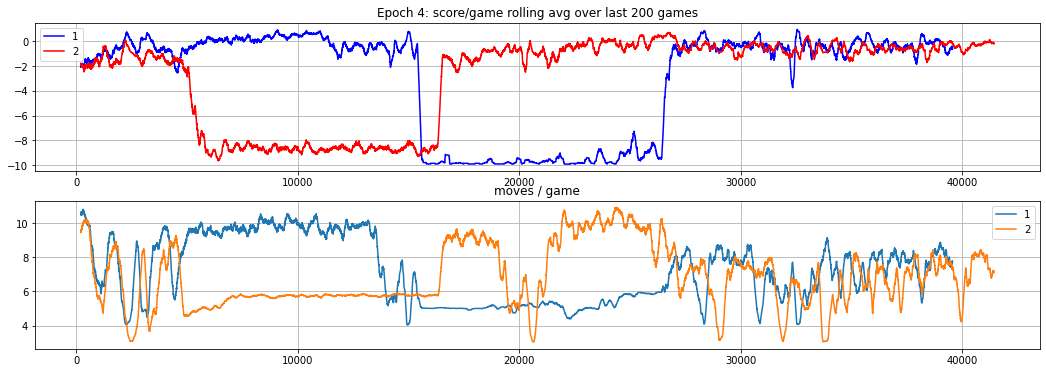

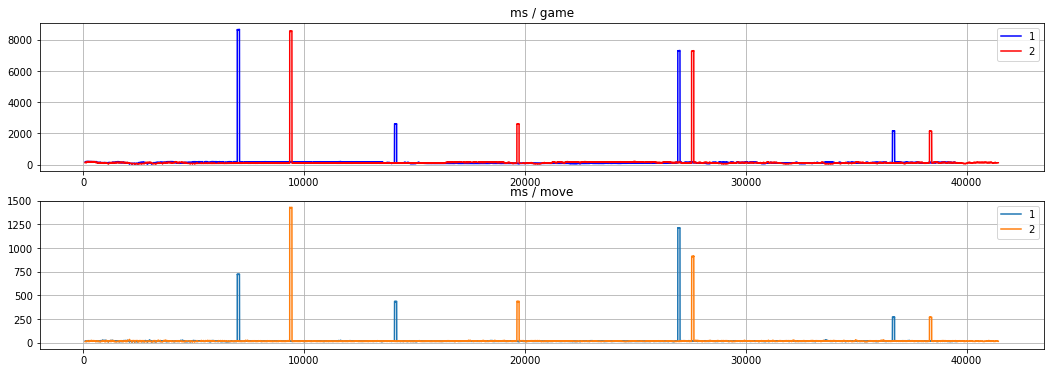

>>> Epoch: 5 Seg: 12 Model: ZZ
>>> New avg high score: 0.63571 	Avg Game steps: 5.23
>>> Epoch: 5 Seg: 13 Model: ZZ
>>> New avg high score: 0.82702 	Avg Game steps: 5.29
Epoch 5 
 5760 steps took 1.0 minutes and 37.34 seconds.
Last Z mean rewards: 0.25774 	Last Z mean steps: 8.04
Last Y mean rewards: -0.61952 	Last Y mean steps: 7.53
Epoch 6 
 5760 steps took 1.0 minutes and 35.19 seconds.
Last Z mean rewards: 0.13690 	Last Z mean steps: 7.80
Last Y mean rewards: -0.36500 	Last Y mean steps: 7.51
Epoch 7 
 5760 steps took 1.0 minutes and 35.12 seconds.
Last Z mean rewards: 0.02464 	Last Z mean steps: 8.76
Last Y mean rewards: -0.40429 	Last Y mean steps: 7.96
Epoch 8 
 5760 steps took 1.0 minutes and 35.58 seconds.
Last Z mean rewards: -0.04012 	Last Z mean steps: 8.55
Last Y mean rewards: -0.35679 	Last Y mean steps: 7.64


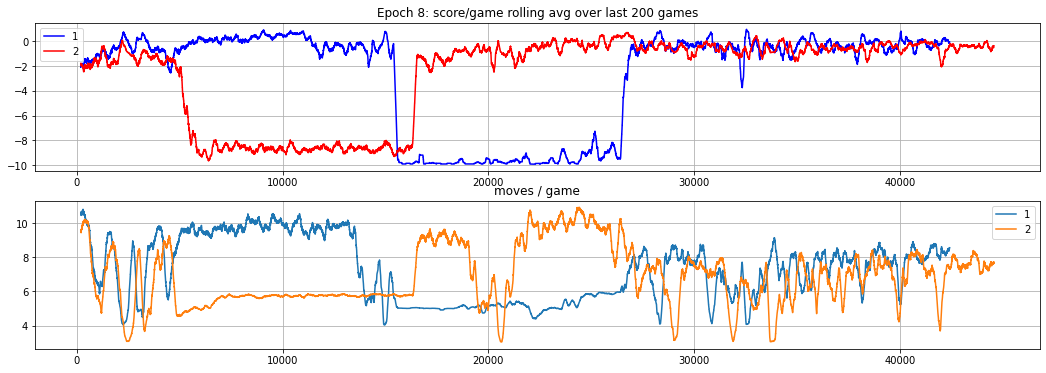

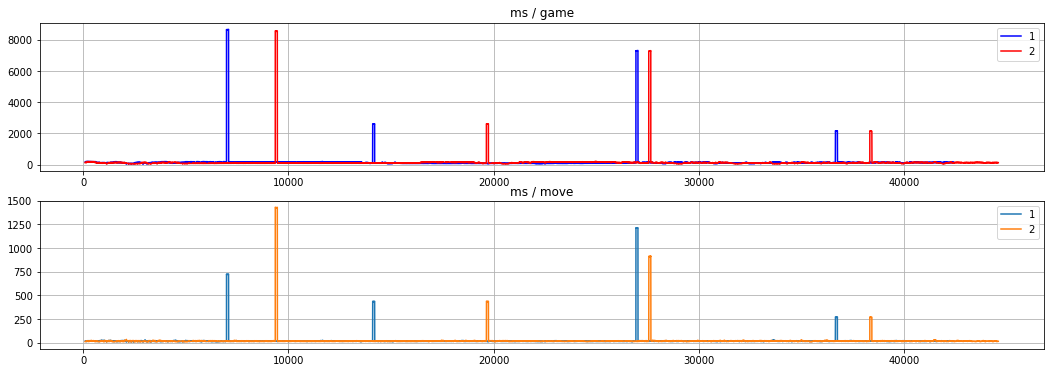

Epoch 9 
 5760 steps took 1.0 minutes and 35.7 seconds.
Last Z mean rewards: -0.45679 	Last Z mean steps: 7.86
Last Y mean rewards: -1.04286 	Last Y mean steps: 7.60
Epoch 10 
 5760 steps took 1.0 minutes and 36.23 seconds.
Last Z mean rewards: -1.20143 	Last Z mean steps: 7.45
Last Y mean rewards: -0.77714 	Last Y mean steps: 7.00
>>> Epoch: 11 Seg: 19 Model: ZZ
>>> New avg high score: 0.84833 	Avg Game steps: 4.71
>>> Epoch: 11 Seg: 20 Model: ZZ
>>> New avg high score: 0.85000 	Avg Game steps: 4.99
Epoch 11 
 5760 steps took 1.0 minutes and 36.68 seconds.
Last Z mean rewards: 0.54036 	Last Z mean steps: 6.05
Last Y mean rewards: -0.91321 	Last Y mean steps: 5.70
Epoch 12 
 5760 steps took 1.0 minutes and 35.07 seconds.
Last Z mean rewards: -0.96940 	Last Z mean steps: 9.01
Last Y mean rewards: -0.07167 	Last Y mean steps: 8.28


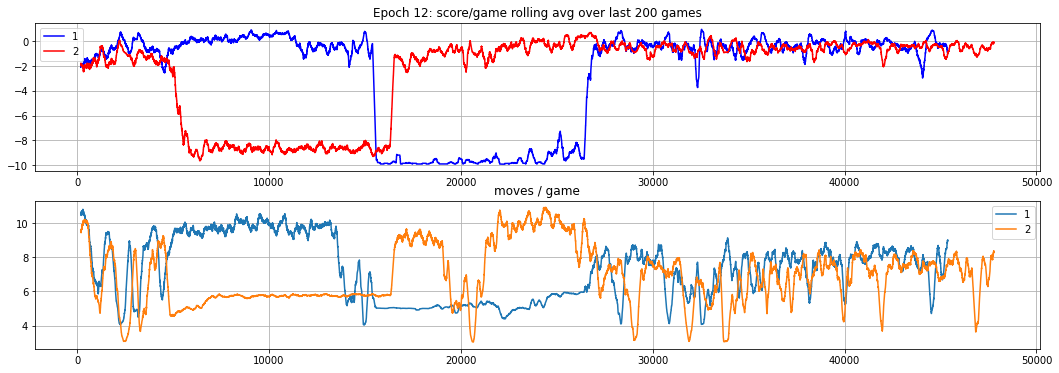

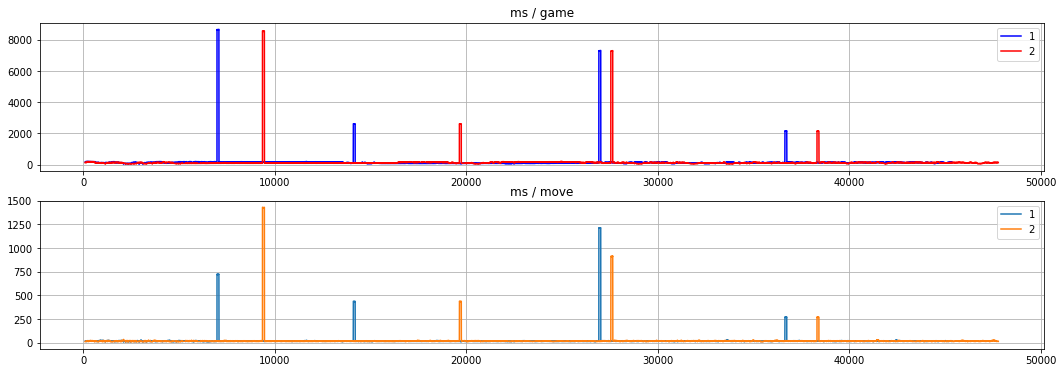

In [ ]:
epochs = 12
lookback = 200

environments = [monitor_envZZ, monitor_envY]
logs = [os.path.join(log_dirZZ, "monitor.csv"),
        os.path.join(log_dirY, "monitor.csv")]
dfs = [pd.DataFrame(columns=['r','l','t']), 
       pd.DataFrame(columns=['r','l','t'])]
models = [modelZZ, modelY]  
mods = ['ZZ', 'Y']
high_scores = [-np.inf, -np.inf]
reward_means = [-np.inf, -np.inf]
length_means = [-np.inf, -np.inf]

for epoch in range(1,epochs+1):
    start = time.time()
    nsteps = 5760
    segments = 24
    for seg in range(segments):
        for i in [0,1]:
            student = models[i]
            student = student.learn(total_timesteps=nsteps//segments)
            reward_means[i] = np.mean(environments[i].episode_rewards[-lookback:])
            length_means[i] = np.mean(environments[i].episode_lengths[-lookback:])
            if reward_means[i] > high_scores[i]:
                high_scores[i] = reward_means[i]
                print(">>> Epoch:", epoch,"Seg:", seg, "Model:", mods[i])
                print(">>> New avg high score: {:.5f} \tAvg Game steps: {:.2f}".format(reward_means[i], length_means[i]))
                student.save("params/highscorer"+mods[i])
    stop = time.time()

    # Plot cumulative rewards and lengths
    print ("Epoch",epoch,"\n",nsteps,"steps took", (stop-start)// 60, "minutes and", round((stop-start) % 60, 2), "seconds.")   
    print("Last Z mean rewards: {:.5f} \tLast Z mean steps: {:.2f}".format(reward_means[0], length_means[0]))
    print("Last Y mean rewards: {:.5f} \tLast Y mean steps: {:.2f}".format(reward_means[1], length_means[1]))

    if epoch % 4 == 0 and not epoch==epochs:
        for i in [0,1]:
            with open(logs[i], 'rt') as fh:    
                firstline = fh.readline()
                assert firstline[0] == '#'
                dfs[i] = pd.read_csv(fh, index_col=None)
        plot_scores(dfs, epoch, lookback)
        #plt.show()
        tdfs = get_times(dfs)
        plot_times(tdfs)
        plt.show()

### Final read out
for i in [0,1]:
    with open(logs[i], 'rt') as fh:    
        firstline = fh.readline()
        assert firstline[0] == '#'
        dfs[i] = pd.read_csv(fh, index_col=None)
plot_scores(dfs, epoch, lookback)
#plt.show()
tdfs = get_times(dfs)
plot_times(tdfs)
plt.show()
modelY.save('params/modelY_params')
modelZZ.save('params/modelZZ_params')

In [ ]:
5760/24

240.0

In [ ]:
modelY.save('params/modelY_params')
modelZZ.save('params/modelZZ_params')


In [ ]:
#files.download('logs/logsZ/monitor.csv') # <-- next save
#files.download('logs/logsZZ/monitor.csv') 
files.download("params/modelY_params.zip")
files.download("params/modelZZ_params.zip")

##Evaluation

In [ ]:
def trained_agent(obs, config, model, debug=False):
    # Use the best model to select a column
    col, _ = model.predict(np.array(obs['board']).reshape(6,7,1))
    if debug:
        print("Player {} predicts: {}".format(obs.mark, col))
    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    # If not valid, select random move. 
    if is_valid:
        return int(col)
    else:
        if debug:
            print(">>> Player {} guesses randomly: {}".format(obs.mark, col))
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [ ]:
def get_win_percentages(agent1, agent2, n_rounds=1):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds)#//2)
    # Agent 2 goes first (roughly) half the time      
    #outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]#
    
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 4))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 4))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))
    #return outcomes

In [ ]:
board = np.array([0, 0, 0, 0, 0, 0, 0,
                  0, 0, 0, 0, 0, 0, 0,
                  0, 0, 0, 0, 0, 0, 0,
                  0, 0, 0, 2, 0, 1, 0,
                  0, 0, 0, 2, 0, 1, 0,
                  0, 0, 0, 2, 0, 1, 1]).reshape((6,7,1))

In [ ]:
modelY.predict(board)

(3, None)

In [ ]:
probs = modelY.action_probability(board)
probs

array([5.0562009e-04, 5.4659904e-04, 4.9186150e-05, 9.9031365e-01,
       7.8501301e-03, 6.0081732e-04, 1.3398443e-04], dtype=float32)

In [ ]:
modelZZ.predict(board)

(3, None)

NameError: ignored

In [ ]:
start_time = time.time()
n_rounds=20
#agent1 = lambda x,y: trained_agent(x, y, model=modelZZ, debug=False)
agent2 = agentY
agent1 = guesstimator  #lambda x,y: deep_agent(x,y,debug=False)
outcomes = get_win_percentages(agent1, agent2, n_rounds=n_rounds)
print ("Total time taken: {} seconds".format(time.time() - start_time))
print ("Time taken per round: {} seconds".format((time.time() - start_time)/n_rounds))

Agent 1 Win Percentage: 0.0
Agent 2 Win Percentage: 0.0
Number of Invalid Plays by Agent 1: 20
Number of Invalid Plays by Agent 2: 0
Total time taken: 3.992168664932251 seconds
Time taken per round: 0.1996133804321289 seconds


In [ ]:
start_time = time.time()
n_rounds=11
agent1 =  "negamax"
agent2 = agentY
outcomes = get_win_percentages(agent1, agent2, n_rounds=n_rounds)
print ("Total time taken: {} seconds".format(time.time() - start_time))
print ("Time taken per round: {} seconds".format((time.time() - start_time)/n_rounds))

In [ ]:
config = {'rows': 6, 'columns': 7, 'inarow': 4}
# Agent 1 goes first (roughly) half the time          
outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
# Agent 2 goes first (roughly) half the time      
outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]#

print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 4))
print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 4))
print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))